In [1]:
import os
import pandas as pd
import glob
import json
import re
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
def extract_random_seed(config_str):
    """Extrai o valor de RANDOM_SEED do string da configuração"""
    try:
        # Usando regex para extrair o valor após 'RANDOM_SEED':
        match = re.search(r"'RANDOM_SEED':\s*(\d+)", config_str)
        if match:
            return int(match.group(1))
        else:
            # Alternativa: convertendo a string para dicionário e acessando a chave
            config_dict = eval(config_str.replace("True", "True").replace("False", "False"))
            return config_dict.get('RANDOM_SEED')
    except:
        return None

In [3]:
def collect_results_from_eniac():
    # Caminho base para o diretório eniac
    base_path = os.path.join(os.getcwd(), '../eniac/n2')
    
    # Lista para armazenar todos os DataFrames
    all_dfs = []
        
    # Percorre todas as pastas datetime dentro de cada abordagem
    for datetime_dir in glob.glob(os.path.join(base_path, '*')):
        datetime_name = os.path.basename(datetime_dir)
        
        # Caminho para o arquivo results.csv
        csv_path = os.path.join(datetime_dir, 'results.csv')
        
        if os.path.exists(csv_path):
            try:
                # Carrega o CSV
                df = pd.read_csv(csv_path)
                
                # Remove a coluna de index original
                if df.columns[0].isdigit() or df.columns[0] == 'Unnamed: 0':
                    df = df.drop(df.columns[0], axis=1)
                
                # Adiciona colunas de abordagem e datetime
                df['approach'] = 'n2'
                df['datetime'] = datetime_name
                
                # Extrai RANDOM_SEED da coluna config e cria uma nova coluna
                df['seed'] = df['config'].apply(extract_random_seed)
                
                # Adiciona o DataFrame à lista
                all_dfs.append(df)
                # print(f"Arquivo processado: {csv_path}")
                
            except Exception as e:
                print(f"Erro ao processar {csv_path}: {e}")
    
    # Concatena todos os DataFrames
    if all_dfs:
        result_df = pd.concat(all_dfs, ignore_index=True)
        return result_df
    else:
        print("Nenhum arquivo CSV foi encontrado ou processado.")
        return None

In [4]:
# Coleta e processa todos os arquivos
combined_df = collect_results_from_eniac()

if combined_df is not None:
    # Mostra estatísticas básicas
    print(f"\nTotal de registros: {len(combined_df)}")
    print(f"Abordagens encontradas: {combined_df['approach'].unique()}")
    print(f"Número de execuções diferentes: {combined_df['datetime'].nunique()}")
    
    # Salva o DataFrame combinado
    combined_df.to_csv('combined_results.csv', index=False)
    print("\nArquivo 'combined_results.csv' salvo com sucesso!")
    
    # Exibe as primeiras linhas para verificação
    print("\nPrimeiras linhas do DataFrame combinado:")
    display(combined_df.tail())


Total de registros: 1884
Abordagens encontradas: ['n2']
Número de execuções diferentes: 471

Arquivo 'combined_results.csv' salvo com sucesso!

Primeiras linhas do DataFrame combinado:


,model_name,rush_precision,rush_recall,rush_f1_score,rush_support,pass_precision,pass_recall,pass_f1_score,pass_support,accuracy,...,macro_f1_score,macro_support,weighted_precision,weighted_recall,weighted_f1_score,weighted_support,config,approach,datetime,seed
1879,MLP,0.700162,0.707038,0.703583,611.0,0.704132,0.697218,0.700658,611.0,0.702128,...,0.702120,1222.0,0.702147,0.702128,0.702120,1222.0,"{'RANDOM_SEED': 8, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-07-21_20-40-37,8
1880,GCN,0.669876,0.797054,0.727952,611.0,0.749495,0.607201,0.670886,611.0,0.702128,...,0.699419,1222.0,0.709686,0.702128,0.699419,1222.0,"{'RANDOM_SEED': 2, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-07-15_23-29-16,2
1881,GCN,0.669876,0.797054,0.727952,611.0,0.749495,0.607201,0.670886,611.0,0.702128,...,0.699419,1222.0,0.709686,0.702128,0.699419,1222.0,"{'RANDOM_SEED': 2, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-07-15_23-29-16,2
1882,RF,0.711480,0.770867,0.739984,611.0,0.750000,0.687398,0.717336,611.0,0.729133,...,0.728660,1222.0,0.730740,0.729133,0.728660,1222.0,"{'RANDOM_SEED': 2, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-07-15_23-29-16,2
1883,MLP,0.698541,0.705401,0.701954,611.0,0.702479,0.695581,0.699013,611.0,0.700491,...,0.700484,1222.0,0.700510,0.700491,0.700484,1222.0,"{'RANDOM_SEED': 2, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-07-15_23-29-16,2


In [5]:

# Lista para armazenar os resultados
best_configs = []

# Para cada abordagem (valores de n)
for approach in combined_df['approach'].unique():
    # Para cada modelo
    for model in ['GCN', 'MLP', 'RF']:
        # Filtrar os dados pela abordagem e modelo
        subset = combined_df[(combined_df['approach'] == approach) & (combined_df['model_name'] == model)]
        
        # Se existirem dados para essa combinação
        if not subset.empty:
            # Encontrar a linha com a maior acurácia
            best_row = subset.loc[subset['accuracy'].idxmax()]
            
            # Extrair as métricas solicitadas
            result = {
                'approach': approach,
                'model_name': model,
                'seed': best_row['seed'],
                'datetime': best_row['datetime'],
                'accuracy': best_row['accuracy'],
                'rush_precision': best_row['rush_precision'],
                'rush_recall': best_row['rush_recall'],
                'rush_f1_score': best_row['rush_f1_score'],
                'pass_precision': best_row['pass_precision'],
                'pass_recall': best_row['pass_recall'],
                'pass_f1_score': best_row['pass_f1_score']
            }
            
            # Adicionar à lista de resultados
            best_configs.append(result)

# Criar um DataFrame com os resultados
best_configs_df = pd.DataFrame(best_configs)

# Ordenar por abordagem e modelo para facilitar a visualização
best_configs_df = best_configs_df.sort_values(['approach', 'model_name'])

# Mostrar os resultados
print("Melhores configurações por abordagem e modelo com métricas:")
display(best_configs_df)

# Salvar os resultados em um arquivo CSV
best_configs_df.to_csv('best_configurations_with_metrics.csv', index=False)
print("\nResultados salvos em 'best_configurations_with_metrics.csv'")

# Opcional: Exibir estatísticas resumidas das métricas
metrics = ['accuracy', 'rush_precision', 'rush_recall', 'rush_f1_score', 
           'pass_precision', 'pass_recall', 'pass_f1_score']

print("\nEstatísticas resumidas das métricas para as melhores configurações:")
for metric in metrics:
    print(f"\n{metric.upper()}:")
    stats = best_configs_df.pivot_table(
        values=metric, 
        index='approach', 
        columns='model_name',
        aggfunc='mean'
    )
    display(stats)

Melhores configurações por abordagem e modelo com métricas:


,approach,model_name,seed,datetime,accuracy,rush_precision,rush_recall,rush_f1_score,pass_precision,pass_recall,pass_f1_score
0,n2,GCN,1,2025-07-15_18-02-19,0.794599,0.765487,0.849427,0.805275,0.830882,0.739771,0.782684
1,n2,MLP,6,2025-07-15_22-05-45,0.751227,0.735069,0.785597,0.759494,0.769772,0.716858,0.742373
2,n2,RF,6,2025-07-15_22-05-45,0.743863,0.719764,0.798691,0.757176,0.773897,0.689034,0.729004



Resultados salvos em 'best_configurations_with_metrics.csv'

Estatísticas resumidas das métricas para as melhores configurações:

ACCURACY:


model_name,GCN,MLP,RF
approach,,,
n2,0.794599,0.751227,0.743863



RUSH_PRECISION:


model_name,GCN,MLP,RF
approach,,,
n2,0.765487,0.735069,0.719764



RUSH_RECALL:


model_name,GCN,MLP,RF
approach,,,
n2,0.849427,0.785597,0.798691



RUSH_F1_SCORE:


model_name,GCN,MLP,RF
approach,,,
n2,0.805275,0.759494,0.757176



PASS_PRECISION:


model_name,GCN,MLP,RF
approach,,,
n2,0.830882,0.769772,0.773897



PASS_RECALL:


model_name,GCN,MLP,RF
approach,,,
n2,0.739771,0.716858,0.689034



PASS_F1_SCORE:


model_name,GCN,MLP,RF
approach,,,
n2,0.782684,0.742373,0.729004


,approach,model_name,accuracy
0,n2,GCN,0.781506
1,n2,MLP,0.750409
2,n2,RF,0.742226
3,n3,GCN,0.762684
4,n3,MLP,0.750409
5,n3,RF,0.742226
6,n4,GCN,0.745499
7,n4,MLP,0.750409
8,n4,RF,0.742226
9,n5,GCN,0.747954


Melhores acurácias por abordagem e modelo:
model_name       GCN       MLP        RF
approach                                
n2          0.781506  0.750409  0.742226
n3          0.762684  0.750409  0.742226
n4          0.745499  0.750409  0.742226
n5          0.747954  0.750409  0.742226
n6          0.747136  0.750409  0.742226
n7          0.741408  0.750409  0.742226
n8          0.737316  0.750409  0.742226
n9          0.734043  0.750409  0.742226

Detalhes das melhores configurações:
   approach model_name  accuracy  seed             datetime
3        n2        GCN  0.781506     8  2025-06-26_19-22-34
5        n2        MLP  0.750409    20  2025-06-26_22-06-00
4        n2         RF  0.742226     9  2025-06-26_19-35-21
15       n3        GCN  0.762684     8  2025-06-27_00-42-17
17       n3        MLP  0.750409    20  2025-06-27_03-30-01
16       n3         RF  0.742226     9  2025-06-27_00-55-18
12       n4        GCN  0.745499     8  2025-06-27_06-09-42
14       n4        MLP  0.750

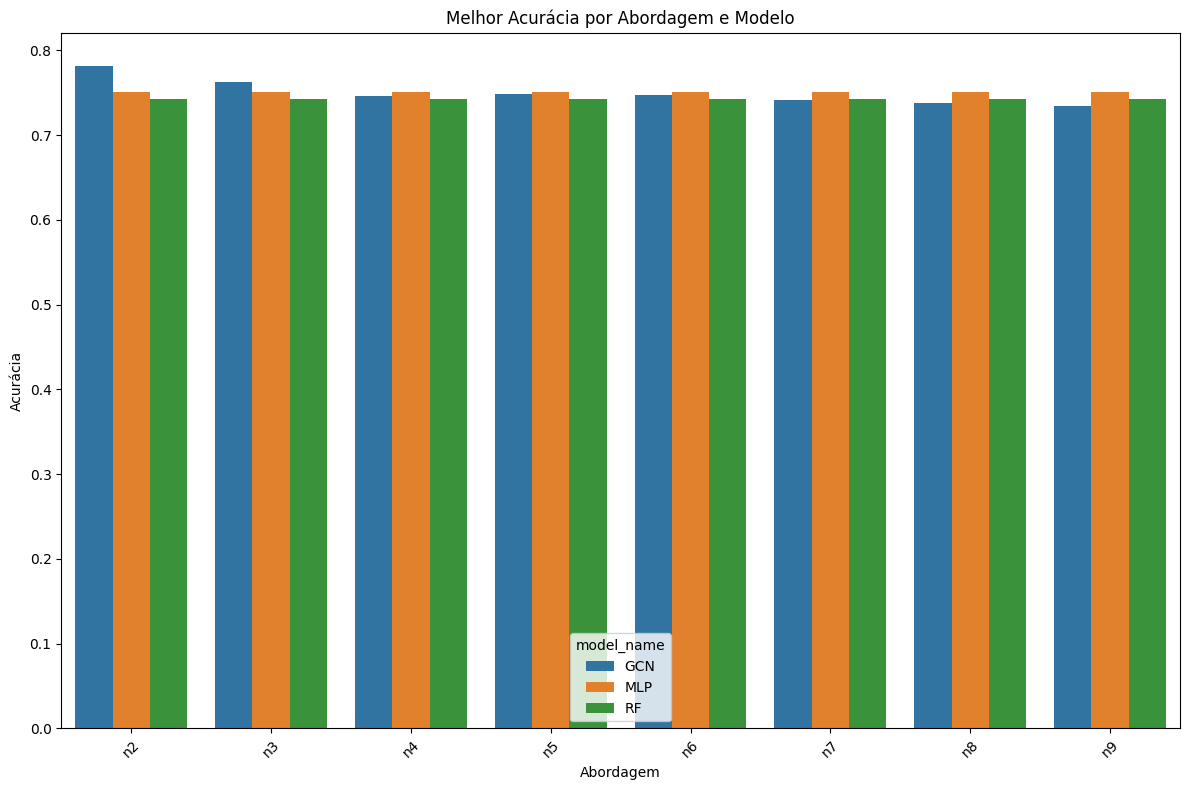

In [46]:
# Agrupar por abordagem e modelo, encontrando a acurácia máxima
best_models = combined_df.groupby(['approach', 'model_name'])['accuracy'].max().reset_index()

# Criar um pivot table para melhor visualização
pivot_best = best_models.pivot(index='approach', columns='model_name', values='accuracy')
display(best_models)

# Mostrar os melhores resultados
print("Melhores acurácias por abordagem e modelo:")
print(pivot_best)

# Encontrar para cada abordagem e modelo, o seed que produziu a melhor acurácia
best_configs = []

for approach in combined_df['approach'].unique():
    for model in ['GCN', 'RF', 'MLP']:
        subset = combined_df[(combined_df['approach'] == approach) & (combined_df['model_name'] == model)]
        if not subset.empty:
            best_row = subset.loc[subset['accuracy'].idxmax()]
            best_configs.append({
                'approach': approach,
                'model_name': model,
                'accuracy': best_row['accuracy'],
                'seed': best_row['seed'],
                'datetime': best_row['datetime']
            })

best_configs_df = pd.DataFrame(best_configs)
best_configs_df = best_configs_df.sort_values(['approach', 'model_name'])

print("\nDetalhes das melhores configurações:")
print(best_configs_df)

# Visualização dos resultados
plt.figure(figsize=(12, 8))
sns.barplot(x='approach', y='accuracy', hue='model_name', data=best_configs_df)
plt.title('Melhor Acurácia por Abordagem e Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Abordagem')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('best_accuracy_by_approach_model.png')
plt.show()

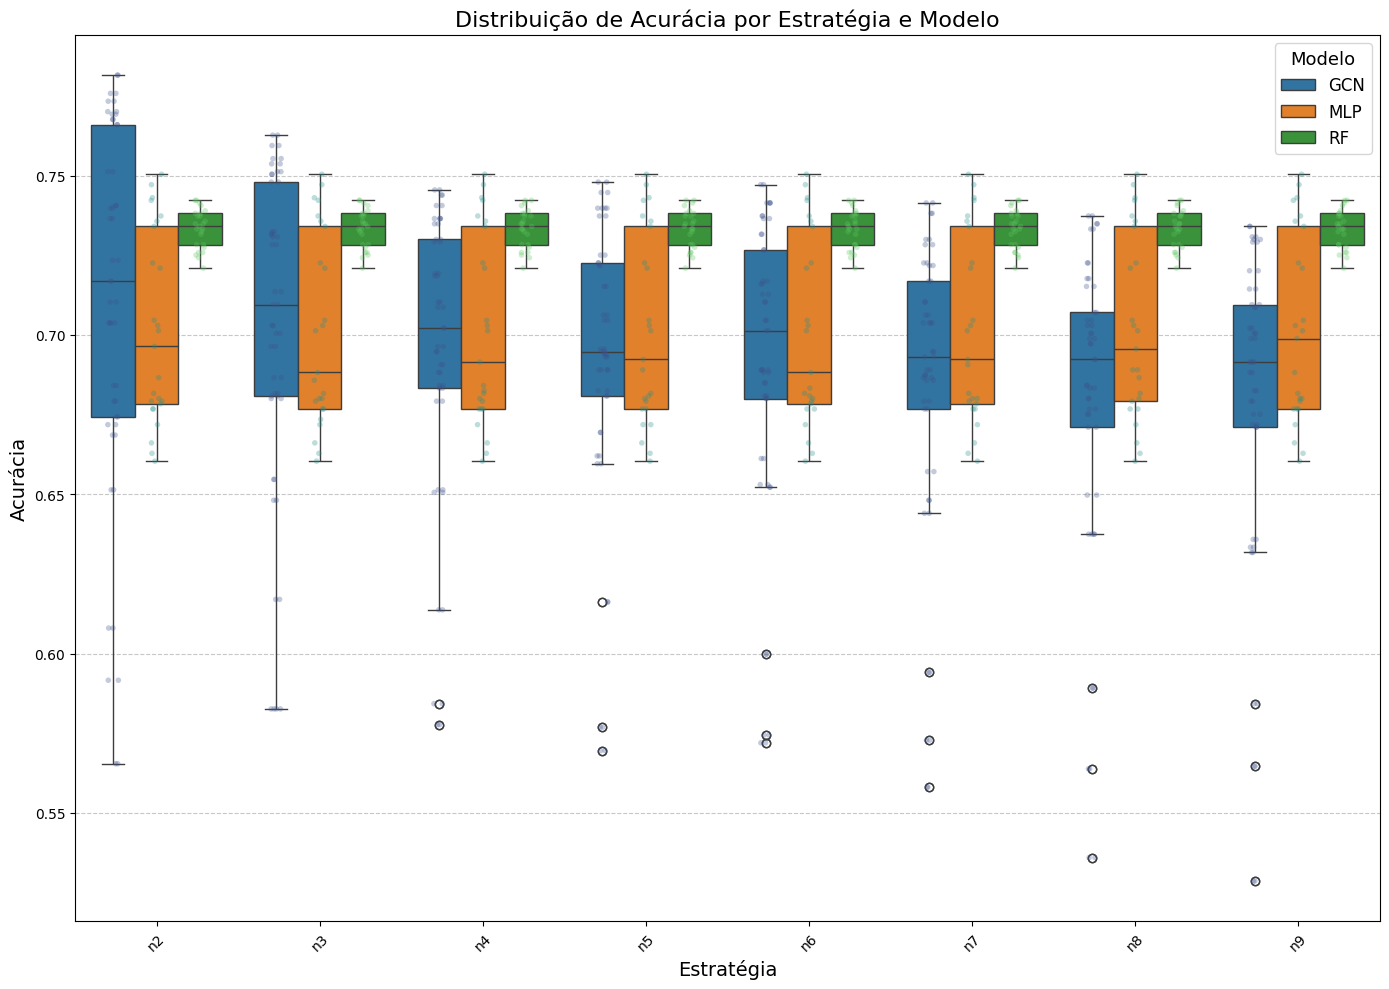


Estatísticas descritivas da acurácia por abordagem e modelo:


count      mean       std       min       25%       50%  \
approach model_name                                                            
n2       GCN          50.0  0.708969  0.059353  0.565466  0.674304  0.716858   
         MLP          25.0  0.701538  0.029842  0.660393  0.678396  0.696399   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n3       GCN          50.0  0.701637  0.051645  0.582651  0.680851  0.709493   
         MLP          25.0  0.701015  0.030109  0.660393  0.676759  0.688216   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n4       GCN          50.0  0.694010  0.046547  0.577741  0.683306  0.702128   
         MLP          25.0  0.701309  0.029908  0.660393  0.676759  0.691489   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n5       GCN          50.0  0.691097  0.046517  0.569558  0.680851  0.694763   
         MLP          25.0  0.701277  0.030026  0.660393  0.676759  0.692308   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n6       GCN          50.0  0.689951  0.048627  0.572013  0.680033  0.701309   
         MLP          25.0  0.701146  0.029971  0.660393  0.678396  0.688216   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n7       GCN          50.0  0.683601  0.048013  0.558101  0.676759  0.693126   
         MLP          25.0  0.701571  0.029784  0.660393  0.678396  0.692308   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n8       GCN          50.0  0.677938  0.051001  0.536007  0.671031  0.692308   
         MLP          25.0  0.702324  0.029329  0.660393  0.679214  0.695581   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   
n9       GCN          50.0  0.676301  0.052742  0.528642  0.671031  0.691489   
         MLP          25.0  0.701669  0.029825  0.660393  0.676759  0.698854   
         RF           25.0  0.733290  0.006128  0.720949  0.728314  0.734043   

                          75%       max  
approach model_name                      
n2       GCN         0.765957  0.781506  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n3       GCN         0.747954  0.762684  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n4       GCN         0.729951  0.745499  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n5       GCN         0.722586  0.747954  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n6       GCN         0.726678  0.747136  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n7       GCN         0.716858  0.741408  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n8       GCN         0.707038  0.737316  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226  
n9       GCN         0.709493  0.734043  
         MLP         0.734043  0.750409  
         RF          0.738134  0.742226


Análise estatística entre abordagens:

Modelo: GCN
  ANOVA: F=2.4584, p=0.0177
  Há diferença estatisticamente significativa entre as abordagens (p<0.05)

Modelo: RF
  ANOVA: F=-0.0000, p=nan
  Não há diferença estatisticamente significativa entre as abordagens (p≥0.05)

Modelo: MLP
  ANOVA: F=0.0046, p=1.0000
  Não há diferença estatisticamente significativa entre as abordagens (p≥0.05)


In [47]:
# Criar um boxplot para visualizar a distribuição de acurácia por abordagem e modelo
plt.figure(figsize=(14, 10))

combined_df = combined_df.sort_values(['approach', 'model_name'])

# Usar seaborn para o boxplot
ax = sns.boxplot(x='approach', y='accuracy', hue='model_name', data=combined_df, showfliers=True)

# Adicionar pontos individuais para melhor visualização
sns.stripplot(x='approach', y='accuracy', hue='model_name', data=combined_df,
             size=4, alpha=0.3, dodge=True, palette='viridis', legend=False)

# Melhorar a aparência
plt.title('Distribuição de Acurácia por Estratégia e Modelo', fontsize=16)
plt.ylabel('Acurácia', fontsize=14)
plt.xlabel('Estratégia', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustar legenda
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[:3], labels[:3], title='Modelo', fontsize=12, title_fontsize=13)

# Adicionar estatísticas de resumo como texto
# for approach in combined_df['approach'].unique():
#     for i, model in enumerate(['GCN', 'RF', 'MLP']):
#         stats = combined_df[(combined_df['approach'] == approach) & 
#                            (combined_df['model_name'] == model)]['accuracy'].describe()
#         if not stats.empty and not pd.isna(stats['mean']):
#             plt.text(list(combined_df['approach'].unique()).index(approach) - 0.3 + (i*0.3), 
#                     0.53, f"μ={stats['mean']:.3f}", fontsize=8, color='darkblue')

plt.tight_layout()
plt.savefig('accuracy_distribution_by_approach_model.png', dpi=300, bbox_inches='tight')
plt.show()

# Tabela de estatísticas descritivas
print("\nEstatísticas descritivas da acurácia por abordagem e modelo:")
stats_df = combined_df.groupby(['approach', 'model_name'])['accuracy'].describe()
display(stats_df)

# Teste para verificar se há diferença estatisticamente significativa entre as abordagens
from scipy import stats

print("\nAnálise estatística entre abordagens:")
for model in ['GCN', 'RF', 'MLP']:
    print(f"\nModelo: {model}")
    approaches = combined_df['approach'].unique()
    if len(approaches) >= 2:  # Só faz sentido se houver pelo menos 2 abordagens
        groups = [combined_df[(combined_df['approach'] == app) & 
                             (combined_df['model_name'] == model)]['accuracy'].values 
                  for app in approaches]
        
        # Filtrar grupos vazios
        groups = [g for g in groups if len(g) > 0]
        
        if len(groups) >= 2:  # Verificar novamente após filtrar
            # ANOVA para testar se há diferença significativa entre as abordagens
            f_stat, p_value = stats.f_oneway(*groups)
            print(f"  ANOVA: F={f_stat:.4f}, p={p_value:.4f}")
            
            if p_value < 0.05:
                print("  Há diferença estatisticamente significativa entre as abordagens (p<0.05)")
            else:
                print("  Não há diferença estatisticamente significativa entre as abordagens (p≥0.05)")

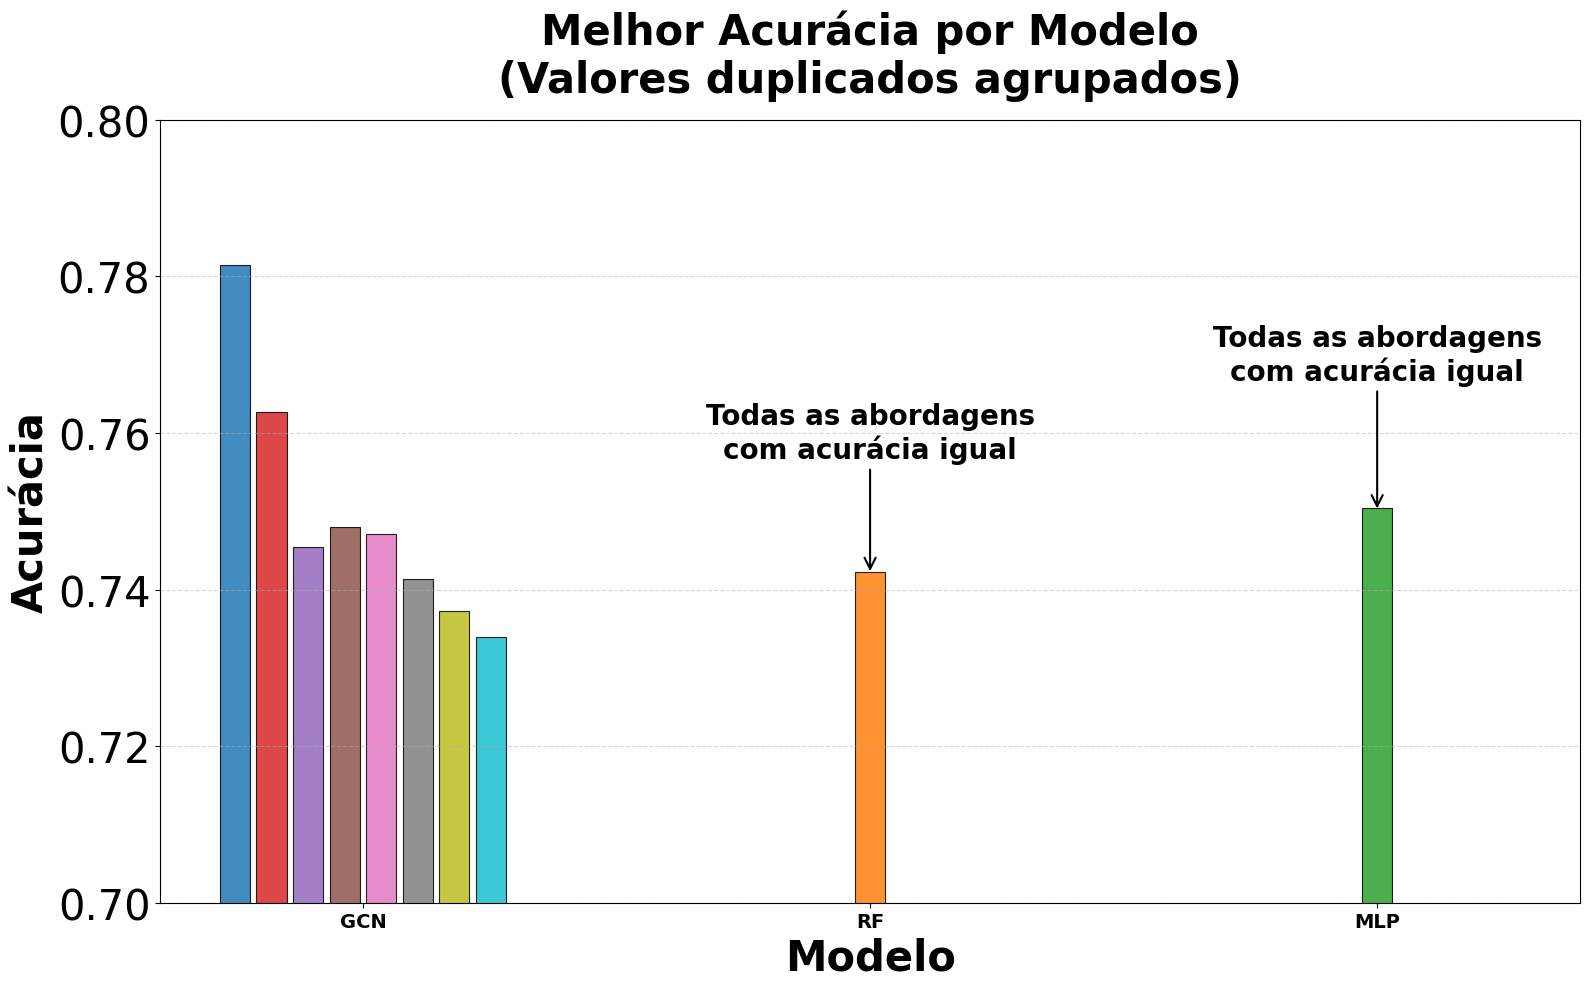

In [86]:
# Visualização melhorada da acurácia por modelo e abordagem
plt.figure(figsize=(16, 10))

# Melhor paleta de cores mais distinguível
colors = plt.cm.Dark2(np.linspace(0, 1, len(approaches)))
color_dict = dict(zip(approaches, colors))

# Criar pontos no eixo x para cada modelo com espaçamento maior
models = ['GCN', 'RF', 'MLP']
x = np.arange(len(models)) * 1.5  # Espaçamento aumentado entre modelos
width = 0.09  # Largura fixa para barras
bar_spacing = width * 1.2  # Espaçamento entre barras

# Rastrear valores já vistos por modelo
model_values = {model: {} for model in models}

# Primeiro, identifique valores únicos para cada modelo
for approach in approaches:
    approach_data = best_configs_df[best_configs_df['approach'] == approach]
    
    for model in models:
        model_data = approach_data[approach_data['model_name'] == model]
        if not model_data.empty:
            value = round(model_data['accuracy'].values[0], 4)  # Arredondar para evitar diferenças por erro de ponto flutuante
            if value not in model_values[model]:
                model_values[model][value] = []
            model_values[model][value].append(approach)

# Plotar apenas a primeira abordagem para cada valor único
bar_objects = []  # Para armazenar os objetos das barras para a legenda
bar_labels = []   # Para armazenar os rótulos para a legenda
bar_count = {model: 0 for model in models}  # Para rastrear quantas barras foram adicionadas por modelo

for i, approach in enumerate(approaches):
    approach_data = best_configs_df[best_configs_df['approach'] == approach]
    
    for j, model in enumerate(models):
        model_data = approach_data[approach_data['model_name'] == model]
        if not model_data.empty:
            value = round(model_data['accuracy'].values[0], 4)
            
            # Só plota se esta abordagem for a primeira na lista para este valor
            if model_values[model][value][0] == approach:
                # Calcular posição da barra considerando quantas já existem neste modelo
                bar_pos = x[j] + (bar_count[model] - (len(model_values[model]) - 1)/2) * bar_spacing
                
                # Plotar a barra
                bar = plt.bar(bar_pos, value, width, 
                             edgecolor='black', linewidth=0.8, alpha=0.85)
                
                if approach not in bar_labels:
                    bar_objects.append(bar)
                    bar_labels.append(approach)
                
                # Adicionar anotação de texto
                approaches_with_same_value = model_values[model][value]
                if len(approaches_with_same_value) > 1:
                    # Formatar múltiplas abordagens de forma mais compacta
                    if len(approaches_with_same_value) > 3:
                        label_text = f"{value:.3f}\n({len(approaches_with_same_value)} abord.)"
                    else:
                        label_text = f"{value:.3f}\n({', '.join(approaches_with_same_value)})"
                else:
                    label_text = f"{value:.3f}\n({approach})"
                
                # plt.text(bar_pos, value + 0.01, label_text, ha='center', va='bottom', 
                #         fontsize=20, fontweight='bold', color='black')
                
                # Incrementar contador de barras para este modelo
                bar_count[model] += 1

# Ajustes estéticos
plt.ylabel('Acurácia', fontsize=30, fontweight='bold')
plt.xlabel('Modelo', fontsize=30, fontweight='bold')
plt.title('Melhor Acurácia por Modelo\n(Valores duplicados agrupados)', fontsize=30, fontweight='bold', pad=20)

# Melhorar eixo X
plt.xticks(x, [f'{model}' for model in models], fontsize=14, fontweight='bold')
plt.xlim(x[0]-0.6, x[-1]+0.6)

# Melhorar eixo Y
plt.ylim(0.70, 0.80)  # Ajuste para focar na faixa relevante dos dados
plt.yticks(np.arange(0.70, 0.81, 0.02), fontsize=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Legenda melhorada
# plt.legend(bar_objects, bar_labels, title='Abordagem', 
#           title_fontsize=13, fontsize=11, 
#           loc='upper center', bbox_to_anchor=(0.5, -0.08),
#           ncol=len(approaches)//2, frameon=True, fancybox=True, shadow=True)

# Adicionar anotações para explicar grupos de abordagens nos casos RF e MLP
plt.annotate('Todas as abordagens\ncom acurácia igual', 
            xy=(x[1], 0.742), xytext=(x[1], 0.76),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
            fontsize=20, ha='center', va='center', fontweight='bold')

plt.annotate('Todas as abordagens\ncom acurácia igual', 
            xy=(x[2], 0.75), xytext=(x[2], 0.77),
            arrowprops=dict(arrowstyle='->', lw=1.5, color='black'),
            fontsize=20, ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_by_model_improved.png', dpi=300, bbox_inches='tight')
plt.show()

In [54]:
# Obter os melhores resultados para cada modelo (maior acurácia)

combined_df = combined_df.sort_values(['accuracy'], ascending=False)
best_models = {}
for model in ['GCN', 'RF', 'MLP']:
    # Filtrar apenas os dados do modelo atual
    model_data = combined_df[combined_df['model_name'] == model]
    
    if not model_data.empty:
        # Encontrar a linha com a maior acurácia
        best_row = model_data.loc[model_data['accuracy'].idxmax()]
        
        best_models[model] = {
            'approach': best_row['approach'],
            'seed': best_row['seed'],
            'datetime': best_row['datetime'],
            'accuracy': best_row['accuracy']
        }

# Criar DataFrame para melhor visualização
best_models_df = pd.DataFrame.from_dict(best_models, orient='index')
best_models_df = best_models_df.reset_index().rename(columns={'index': 'model_name'})

# Ordenar por acurácia (decrescente)
best_models_df = best_models_df.sort_values('accuracy', ascending=False)

# Mostrar os resultados
print("Melhores resultados por modelo:")
display(best_models_df)

# Mostrar as informações completas das melhores execuções
print("\nInformações completas dos melhores modelos:")
for model, info in best_models.items():
    print(f"\nMelhor {model}:")
    best_execution = combined_df[
        (combined_df['model_name'] == model) & 
        (combined_df['approach'] == info['approach']) & 
        (combined_df['seed'] == info['seed']) &
        (combined_df['datetime'] == info['datetime'])
    ]
    display(best_execution)

Melhores resultados por modelo:


,model_name,approach,seed,datetime,accuracy
0,GCN,n2,8,2025-06-26_19-22-34,0.781506
2,MLP,n3,20,2025-06-27_03-30-01,0.750409
1,RF,n4,10,2025-06-27_06-41-15,0.742226



Informações completas dos melhores modelos:

Melhor GCN:


,model_name,rush_precision,rush_recall,rush_f1_score,rush_support,pass_precision,pass_recall,pass_f1_score,pass_support,accuracy,...,macro_f1_score,macro_support,weighted_precision,weighted_recall,weighted_f1_score,weighted_support,config,approach,datetime,seed
100,GCN,0.746418,0.8527,0.796028,611.0,0.828244,0.710311,0.764758,611.0,0.781506,...,0.780393,1222.0,0.787331,0.781506,0.780393,1222.0,"{'RANDOM_SEED': 8, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-06-26_19-22-34,8
101,GCN,0.746418,0.8527,0.796028,611.0,0.828244,0.710311,0.764758,611.0,0.781506,...,0.780393,1222.0,0.787331,0.781506,0.780393,1222.0,"{'RANDOM_SEED': 8, 'GNN_EPOCHS': 500, 'GNN_HID...",n2,2025-06-26_19-22-34,8



Melhor RF:


,model_name,rush_precision,rush_recall,rush_f1_score,rush_support,pass_precision,pass_recall,pass_f1_score,pass_support,accuracy,...,macro_f1_score,macro_support,weighted_precision,weighted_recall,weighted_f1_score,weighted_support,config,approach,datetime,seed
434,RF,0.722892,0.785597,0.752941,611.0,0.765233,0.698854,0.730539,611.0,0.742226,...,0.74174,1222.0,0.744062,0.742226,0.74174,1222.0,"{'RANDOM_SEED': 10, 'GNN_EPOCHS': 500, 'GNN_HI...",n4,2025-06-27_06-41-15,10



Melhor MLP:


,model_name,rush_precision,rush_recall,rush_f1_score,rush_support,pass_precision,pass_recall,pass_f1_score,pass_support,accuracy,...,macro_f1_score,macro_support,weighted_precision,weighted_recall,weighted_f1_score,weighted_support,config,approach,datetime,seed
547,MLP,0.734663,0.783961,0.758511,611.0,0.768421,0.716858,0.741744,611.0,0.750409,...,0.750128,1222.0,0.751542,0.750409,0.750128,1222.0,"{'RANDOM_SEED': 20, 'GNN_EPOCHS': 500, 'GNN_HI...",n3,2025-06-27_03-30-01,20
